In [3]:
%load_ext autoreload
%autoreload 2

In [15]:
import rdkit
from rdkit import Chem
from openbabel import pybel

import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
import sys
sys.path.append('../evaluation/')
sys.path.append('..')
from torch_geometric.loader import DataLoader
import torch
import subprocess

In [16]:
from data_processing.paired_data import CombinedSparseGraphDataset, CombinedSparseGraphDataset
from data_processing.ligand import Ligand
from utils_eval import build_pdb_dict

# Save pdb file of ligand as well

In [24]:
TYPES_FILENAME = 'types/it2_tt_v1.3_completeset_train0.types'  # 'types/it2_tt_completeset_train0.types'
source = '/data/conghao001/protein2drug/data/CrossDocked2020'
dest = '../../data/cleaned_crossdocked_data/raw'
types_path = os.path.join(source, '..', TYPES_FILENAME)

In [21]:
with open(types_path, 'r') as f:
    for ln in tqdm(f.readlines()[:100]):
        _, _, rmsd, protein_fn, ligand_fn, _ = ln.split()
        rmsd = float(rmsd)
        if rmsd > 1.0: 
            continue

        print(ligand_fn.rfind('_'), ligand_fn.rfind('.'))
        ligand_pdb = ligand_fn[ligand_fn.rfind('rec')+4:ligand_fn.rfind('lig')+3]
        print(ligand_pdb)
        ligand_pdb_path = os.path.join(source, ligand_fn.split('/')[0], ligand_pdb+'.pdb')
        print(ligand_pdb_path)
        
        ligand_id = int(ligand_fn[ligand_fn.rfind('_')+1:ligand_fn.rfind('.')])

        protein_fn = protein_fn[:protein_fn.rfind('_')] + '.pdb'
        # For CrossDocked v1.0
        # ligand_raw_fn = ligand_fn[:ligand_fn.rfind('_')] + '.sdf'
        ligand_raw_fn = ligand_fn[:ligand_fn.rfind('_')] + '.sdf.gz'
        protein_path = os.path.join(source, protein_fn)
        ligand_raw_path = os.path.join(source, ligand_raw_fn)

        print(ligand_id, ligand_raw_fn, ligand_raw_path, protein_fn, protein_path)
        if not (os.path.exists(protein_path) and os.path.exists(ligand_raw_path)):
            continue

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 268349.58it/s]

50 52
5u98_1kx_lig
/data/conghao001/protein2drug/data/CrossDocked2020/1B57_HUMAN_25_300_0/5u98_1kx_lig.pdb
0 1B57_HUMAN_25_300_0/3vrj_A_rec_5u98_1kx_lig_tt_min.sdf.gz /data/conghao001/protein2drug/data/CrossDocked2020/1B57_HUMAN_25_300_0/3vrj_A_rec_5u98_1kx_lig_tt_min.sdf.gz 1B57_HUMAN_25_300_0/3vrj_A_rec.pdb /data/conghao001/protein2drug/data/CrossDocked2020/1B57_HUMAN_25_300_0/3vrj_A_rec.pdb


In [ ]:
for folder in tqdm(os.listdir(source)):
    files = glob.glob(os.path.join(source, folder, '*_lig.pdb'))
    # print(files)
    for file in files:
        subprocess.run(['cp', file, os.path.join(dest, folder)+'/'])

  0%|▋                                                                                                                                                       | 12/2907 [00:00<01:15, 38.46it/s]cp: cannot create regular file '../../data/cleaned_crossdocked_data/raw/FABI_ECOLI_1_262_0/': Not a directory
cp: cannot create regular file '../../data/cleaned_crossdocked_data/raw/FABI_ECOLI_1_262_0/': Not a directory
cp: cannot create regular file '../../data/cleaned_crossdocked_data/raw/FABI_ECOLI_1_262_0/': Not a directory
cp: cannot create regular file '../../data/cleaned_crossdocked_data/raw/FABI_ECOLI_1_262_0/': Not a directory
cp: cannot create regular file '../../data/cleaned_crossdocked_data/raw/FABI_ECOLI_1_262_0/': Not a directory
cp: cannot create regular file '../../data/cleaned_crossdocked_data/raw/FABI_ECOLI_1_262_0/': Not a directory
cp: cannot create regular file '../../data/cleaned_crossdocked_data/raw/FABI_ECOLI_1_262_0/': Not a directory
cp: cannot create regular file '../../d

# Check the ratio of P S Cl in the generated molecules

In [8]:
raw_data_path = '../../data/cleaned_crossdocked_data/raw'
docked = os.listdir(raw_data_path)
len(docked)

2402

In [9]:
raw_files = []
for folder in docked:
    raw_files += glob.glob(os.path.join(raw_data_path, folder, '*.sdf'))
    
len(raw_files)

242360

In [ ]:
mols = [Chem.MolFromMolFile(f, sanitize=False) for f in tqdm(raw_files)]
len(mols)


 19%|███████████████████████████▌                                                                                                                       | 45410/242360 [01:56<07:58, 411.81it/s]


In [14]:
def check_p_s_cl(mols):
    n_mols_with_p = 0
    n_mols_with_s = 0
    n_mols_with_cl = 0
    n_all = 0

    for mol in tqdm(mols):
        if mol == None:
             continue
        atomic_nums = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    #     print(atomic_nums)
        if 15 in atomic_nums:
            n_mols_with_p += 1
        if 16 in atomic_nums:
            n_mols_with_s += 1
        if 17 in atomic_nums:
            n_mols_with_cl += 1
            
        if 15 in atomic_nums or 16 in atomic_nums or 17 in atomic_nums:
            n_all += 1

    print(n_mols_with_p, n_mols_with_s, n_mols_with_cl, n_all)
    return n_mols_with_p, n_mols_with_s, n_mols_with_cl, n_all

In [ ]:
check_p_s_cl(mols)

In [11]:
gen_res_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_44_27.850031/reconstructed_mols_aromatic_mode'
gen_filenames = os.listdir(gen_res_path)
gen_files = [os.path.join(gen_res_path, gen_filename) for gen_filename in gen_filenames]
len(gen_files)

16395

In [12]:
gen_mols = [Chem.MolFromMolFile(f, sanitize=True) for f in tqdm(gen_files)]
len(gen_mols)

  0%|                                                                                                                                                                 | 0/16395 [00:00<?, ?it/s][17:57:23] atom 8 has specified valence (3) smaller than the drawn valence 4.
[17:57:23] atom 0 has specified valence (1) smaller than the drawn valence 2.
[17:57:23] atom 5 has specified valence (1) smaller than the drawn valence 2.
[17:57:23] atom 12 has specified valence (3) smaller than the drawn valence 4.
[17:57:23] atom 0 has specified valence (3) smaller than the drawn valence 4.
[17:57:23] atom 3 has specified valence (1) smaller than the drawn valence 2.
[17:57:23] atom 1 has specified valence (5) smaller than the drawn valence 6.
[17:57:23] atom 15 has specified valence (2) smaller than the drawn valence 3.
[17:57:23] atom 6 has specified valence (1) smaller than the drawn valence 2.
[17:57:23] atom 2 has specified valence (2) smaller than the drawn valence 3.
[17:57:23] atom 0 has spec

16395

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1466/1466 [00:00<00:00, 5199.41it/s]


1466

In [15]:
check_p_s_cl(gen_mols)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16395/16395 [00:01<00:00, 14834.88it/s]

10163 9925 0 13349


(10163, 9925, 0, 13349)

# check the ratio of P, S, Cl in processed dataset

In [4]:
root = '../../data/cleaned_crossdocked_data'
split = 'train'
dataset = CombinedSparseGraphDataset(root, split, aromatic=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [5]:
one = next(iter(dataloader))
one

DataBatch(x=[132, 12], pos=[132, 3], target_x=[132, 12], target_pos=[132, 3], Gt_mask=[132], ligand_name=[1], batch=[132], ptr=[2])

In [6]:
one_class = torch.argmax(one.x[one.Gt_mask], dim=-1)
one_class

tensor([0, 4, 0, 4, 0, 2, 0, 4, 0, 2, 0, 4, 0, 0, 2, 0, 4, 4, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 4, 2, 0, 0, 4, 2, 0, 0, 0, 4, 2,
        4, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [7]:
n_all = 0
n_p = 0
n_s = 0
n_cl = 0
for batch in tqdm(dataloader):
    x = batch.x[batch.Gt_mask]
    assert x.size(0) == batch.x.size(0)//2
    x_class = torch.argmax(x, dim=-1)
    
    
    # if any(element in range(8, 13) for element in x_class):
    #     n_all += 1
    #     if any(element in [8, 9] for element in x_class):
    #         n_p += 1
    #     if any(element in [10, 11] for element in x_class):
    #         n_s += 1
    #     if any(element == 12 for element in x_class):
    #         n_cl += 1

    if any(element in range(7, 12) for element in x_class):
        n_all += 1
        if any(element in [7, 8] for element in x_class):
            n_p += 1
        if any(element in [9, 10] for element in x_class):
            n_s += 1
        if any(element == 11 for element in x_class):
            n_cl += 1
            
print(n_p, n_s, n_cl, n_all)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181471/181471 [10:53<00:00, 277.57it/s]

20517 36472 21636 71312


In [40]:
len(dataset)

184026

# Check QM9

In [24]:
raw_path = '../../data/qm9/raw/gdb9.sdf'
suppl = Chem.SDMolSupplier(raw_path, removeHs=False, sanitize=True)
pbmols = list(pybel.readfile("sdf", raw_path))

In [8]:
with open('../../data/qm9/raw/uncharacterized.txt', 'r') as f:
    skip = [int(x.split()[0]) - 1 for x in f.read().split('\n')[9:-2]]

In [26]:
skip_num=0
for i, rdmol in enumerate(tqdm(suppl)):
    if i >= 10000:
        break
        
    if i in skip:
        skip_num += 1
        continue

    if rdmol is None:
        skip_num += 1
        continue
        
    smiles = Chem.MolToSmiles(rdmol)
    pbmol = pbmols[i]
    try:
        rdmol = Chem.AddHs(rdmol)
        ligand = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None)
    except Exception as e:
        print(smiles, 'Ligand init failed')
        print(e)
        continue

  0%|                                                                                                                                                              | 87/133885 [00:00<02:35, 858.40it/s][14:13:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[14:13:48] ERROR: Could not sanitize molecule ending on line 2704
[14:13:48] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
  0%|▎                                                                                                                                                            | 258/133885 [00:00<02:43, 817.44it/s][14:13:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[14:13:48] ERROR: Could not sanitize molecule ending on line 9097
[14:13:48] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
  0%|▋                                                                                                                                                            

  3%|████                                                                                                                                                        | 3524/133885 [00:03<02:11, 993.41it/s][14:13:51] Explicit valence for atom # 3 C, 5, is greater than permitted
[14:13:51] ERROR: Could not sanitize molecule ending on line 122888
[14:13:51] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[14:13:51] Explicit valence for atom # 3 C, 5, is greater than permitted
[14:13:51] ERROR: Could not sanitize molecule ending on line 123006
[14:13:51] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[14:13:51] Explicit valence for atom # 3 C, 5, is greater than permitted
[14:13:51] ERROR: Could not sanitize molecule ending on line 123116
[14:13:51] ERROR: Explicit valence for atom # 3 C, 5, is greater than permitted
[14:13:51] Explicit valence for atom # 1 C, 5, is greater than permitted
[14:13:51] ERROR: Could not sanitize molecule ending on line 123

# check if the pyg dataset is saved correctly

In [13]:
root_path = '../../data/cleaned_crossdocked_data'
dataset = CombinedSparseGraphDataset(root=root_path, split='test', aromatic=True, filtering=False)

In [11]:
one = dataset[1234]
one

Data(x=[88, 12], pos=[88, 3], target_x=[88, 12], target_pos=[88, 3], Gt_mask=[88], ligand_name='5kcp_A_rec_1adb_cnd_lig_tt_min_0')

In [18]:
ligand_name = one.ligand_name
ligand_name

'5kcp_A_rec_1adb_cnd_lig_tt_min_0'

In [17]:
raw_data_path = os.path.join(root_path, 'raw')
pdb_dict, pdb_rev_dict = build_pdb_dict(raw_data_path)

In [21]:
pdb_folder = pdb_rev_dict[ligand_name+'.sdf']
lig_file = os.path.join(raw_data_path, pdb_folder, ligand_name+'.sdf')
lig_file

'../../data/cleaned_crossdocked_data/raw/ADH1E_HORSE_2_375_0/5kcp_A_rec_1adb_cnd_lig_tt_min_0.sdf'

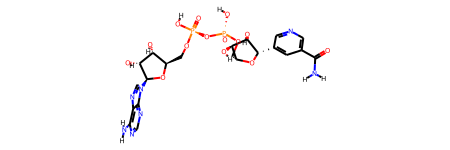

In [22]:
rdmol = Chem.MolFromMolFile(lig_file, removeHs=False, sanitize=True)
rdmol

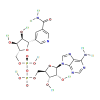

In [23]:
pbmol = next(pybel.readfile("sdf", lig_file))
pbmol

In [24]:
rdmol = Chem.AddHs(rdmol)
ligand = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None, filtering=False)
rdmol = ligand.rdmol_noH

In [26]:
for node in ligand.graph.nodes:
    print(node.positions.squeeze())
    print(node.types, node.index)
    atom_indices = list([node.atom_indices]) if type(node.atom_indices)==int else list(sorted(node.atom_indices))
    print(atom_indices)

[-9.879951  55.078716   5.7809505]
['Aromatic'] 0
[15, 16, 18, 19, 20, 21]
[ 3.4455998 61.675785   8.101417 ]
['Aromatic'] 1
[35, 36, 37, 38, 39, 40]
[-4.8797 62.7294  4.571 ]
['Anion'] 2
[0, 1, 2, 3, 22]
[-8.5799 61.5378  3.0607]
['HBond_donor'] 3
[8]
[-10.5176  59.9519   3.6527]
['HBond_donor'] 4
[10]
[-10.8188  54.1466   8.2642]
['HBond_donor'] 5
[17]
[-1.8688 64.1727  4.8633]
['HBond_donor'] 6
[24]
[-2.1761 60.9257  9.713 ]
['HBond_donor'] 7
[31]
[-0.1426 62.4303 10.3229]
['HBond_donor'] 8
[33]
[ 5.6832 59.0245  9.6496]
['HBond_donor'] 9
[43]
[-7.4632 58.6857  4.7159]
['HBond_acceptor'] 10
[6]
[-10.1232  56.9976   7.6648]
['HBond_acceptor'] 11
[14]
[-2.0871 61.9483  3.5099]
['HBond_acceptor'] 12
[25]
[-0.9346 61.7905  5.8659]
['HBond_acceptor'] 13
[26]
[ 0.2661 59.9462  7.8479]
['HBond_acceptor'] 14
[29]
[ 6.8224 61.0255  9.3867]
['HBond_acceptor'] 15
[42]


In [28]:
one.target_x[one.Gt_mask]

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0

In [29]:
one.target_pos

tensor([[ -4.8829,  62.7247,   4.5857],
        [ -4.8744,  62.7261,   4.5777],
        [ -4.8814,  62.7254,   4.5796],
        [ -4.8829,  62.7351,   4.5770],
        [ -8.3929,  59.3293,   4.9434],
        [ -8.4047,  59.3372,   4.9449],
        [ -7.4636,  58.6714,   4.7167],
        [ -8.4016,  59.3431,   4.9329],
        [ -8.5785,  61.5449,   3.0513],
        [ -8.4043,  59.3441,   4.9305],
        [-10.5105,  59.9453,   3.6598],
        [ -8.3987,  59.3314,   4.9501],
        [ -8.3944,  59.3385,   4.9314],
        [ -8.3909,  59.3199,   4.9542],
        [-10.1297,  57.0045,   7.6546],
        [ -9.8675,  55.0804,   5.7760],
        [ -9.8765,  55.0707,   5.7898],
        [-10.8182,  54.1554,   8.2547],
        [ -9.8936,  55.0642,   5.7839],
        [ -9.8830,  55.0687,   5.7826],
        [ -9.8733,  55.0802,   5.7766],
        [ -9.8726,  55.0666,   5.7988],
        [ -4.8829,  62.7350,   4.5778],
        [ -0.9154,  61.2470,   7.5528],
        [ -1.8780,  64.1796,   4.8720],
